In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [3]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Neural Network
import keras 
from keras.models import Sequential 
from keras.layers import Dense

In [6]:
# load the data
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL - Titanic Survival/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL - Titanic Survival/test.csv')
df = df_train.append(df_test , ignore_index = True)

In [7]:
# some quick inspections
print(df_train.shape, df_test.shape, df_train.columns.values)

(891, 12) (418, 11) ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [8]:
# Data Preprocessing
# check if there is any NAN
df['Pclass'].isnull().sum(axis=0)

0

In [9]:
# inspect the correlation between Pclass and Survived
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [ ]:
# a higher class (lower value) has a higher survival rate.

In [10]:
# Name of passenger
df.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [ ]:
# Each person's title gives information of gender or status. this relates to the survival factor.

In [11]:
# extract the titles
df['Title'] = df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())

# inspect the amount of people for each title
df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
Jonkheer          1
Capt              1
Lady              1
Don               1
Sir               1
Dona              1
the Countess      1
Name: Title, dtype: int64

In [ ]:
# main ones are "Master", "Miss", "Mr", "Mrs". rest of them can be merged as "others".

In [12]:
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
df.Title.loc[ (df.Title !=  'Master') & (df.Title !=  'Mr') & (df.Title !=  'Miss') 
             & (df.Title !=  'Mrs')] = 'Others'


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [13]:
# inspect the correlation between Title and Survived
df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.701087
2,Mr,0.156673
3,Mrs,0.796875
4,Others,0.318182


In [14]:
# inspect the amount of people for each title
df['Title'].value_counts()

Mr        757
Miss      262
Mrs       201
Master     61
Others     28
Name: Title, dtype: int64

In [ ]:
#  use dummy varaibles for these titles and drop original names

In [15]:
df = pd.concat([df, pd.get_dummies(df['Title'])], axis=1).drop(labels=['Name'], axis=1)

In [16]:
# check if there is any NAN in sex column
df.Sex.isnull().sum(axis=0)

0

In [17]:
#  inspect the correlation between Sex and Survived
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [19]:
# map the two genders to 0 and 1
df.Sex = df.Sex.map({'male':0, 'female':1})

In [20]:
# check if there is any NAN in age column
df.Age.isnull().sum(axis=0)

263

In [ ]:
# There are 263 missing values.

In [21]:
# check if there is any NAN in "Siblings/spouses aboard" coloumn
df.SibSp.isnull().sum(axis=0), df.Parch.isnull().sum(axis=0)

(0, 0)

In [22]:
# create a new feature "Family" collaborating "siblings" column and "parents/children" column
df['Family'] = df['SibSp'] + df['Parch'] + 1


In [23]:
# inspect the correlation between Family and Survived
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [24]:
# inspect the amount of people for each Family size
df['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

In [ ]:
# We can see that the survival rate increases with the family size, but not beyond Family = 4. 
# Also, the amount of people in big families is much lower than those in small families. 
# I will combine all the data with Family > 4 into one category. Since people in big families have an even 
# lower survival rate (0.161290) than those who are alone, 
# I decided to map data with Family > 4 to Family = 0, such that the survival rate always increases as Family increases.

In [25]:
df.Family = df.Family.map(lambda x: 0 if x > 4 else x)
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,0,0.161290
1,1,0.303538
2,2,0.552795
3,3,0.578431
4,4,0.724138


In [26]:
df['Family'].value_counts()

1    790
2    235
3    159
0     82
4     43
Name: Family, dtype: int64

In [ ]:
# Ticket

In [27]:
# check if there is any NAN
df.Ticket.isnull().sum(axis=0)

0

In [28]:
df.Ticket.head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

In [ ]:
# It looks like there are two types of tickets: (1) number (2) letters + number
# Ticket names with letters probably represent some special classes. For the numbers, the majority of tickets have their first
# digit = 1, 2, or 3, which probably also represent different classes. So I just keep the first element 
# (a letter or a single-digit number) of these ticket names

In [29]:
df.Ticket = df.Ticket.map(lambda x: x[0])

# inspect the correlation between Ticket and Survived
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.200000
4,5,0.000000
5,6,0.166667
6,7,0.111111
7,8,0.000000
8,9,1.000000
9,A,0.068966


In [30]:
# inspect the amount of people for each type of tickets
df['Ticket'].value_counts()

3    429
2    278
1    210
P     98
S     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket, dtype: int64

We can see that the majority of tickets are indeed "3", "2", and "1", and their corresponding survival rates are "1" > "2" > "3". For the others, the survival rate is low except for "9","C","F","P", and "S". However, "9" and "F" are very small sample. The correlation we see here probably comes from Pclass or Fare, so let's check.


In [31]:
df[['Ticket', 'Fare']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Fare
0,1,65.771211
1,2,20.235194
2,3,15.380682
3,4,16.764036
4,5,19.262500
5,6,19.153711
6,7,9.197438
7,8,8.397900
8,9,7.750000
9,A,10.189681


In [32]:
df[['Ticket', 'Pclass']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Pclass
0,1,1.147619
1,2,2.309353
2,3,2.904429
3,4,3.000000
4,5,2.333333
5,6,2.111111
6,7,3.000000
7,8,3.000000
8,9,3.000000
9,A,3.000000


Indeed, there is some relation between Ticket and Fare, or between Ticket and Pclass. Also, one interesting thing is that "P" corresponds to very high Fare and Pcalss (better than "1"). This is an additional information that cannot be seen in other features. So keeping Ticket as a feature might be useful.

I'll come back to Ticket later. I don't further transform it now because its current form might be useful for guessing some missing values in other features.

In [33]:
# Fare
# check if there is any NAN
df.Fare.isnull().sum(axis=0)

1

Only one missing value. Fare can probably be inferred from Ticket, Pclass, Cabin and Embarked. Let's see the corresponding values of for these features.

In [34]:
df.Ticket[df.Fare.isnull()]

1043    3
Name: Ticket, dtype: object

In [35]:
df.Pclass[df.Fare.isnull()]

1043    3
Name: Pclass, dtype: int64

In [36]:
df.Embarked[df.Fare.isnull()]

1043    S
Name: Embarked, dtype: object

No corresponding value for Cabin, hence check the relation between Fare and the other three features.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


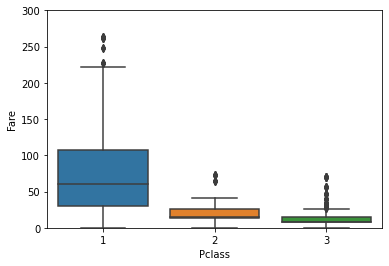

In [37]:
# use boxplot to visualize the distribution of Fare for each Pclass
sns.boxplot('Pclass','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [38]:
# inspect the correlation between Pclass and Fare
df[['Pclass', 'Fare']].groupby(['Pclass']).mean()

,Fare
Pclass,
1,87.508992
2,21.179196
3,13.302889


In [39]:
# divide the standard deviation by the mean. A lower ratio means a tighter distribution of Fare in each Pclass
df[['Pclass', 'Fare']].groupby(['Pclass']).std() / df[['Pclass', 'Fare']].groupby(['Pclass']).mean()

,Fare
Pclass,
1,0.919302
2,0.642476
3,0.864050


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


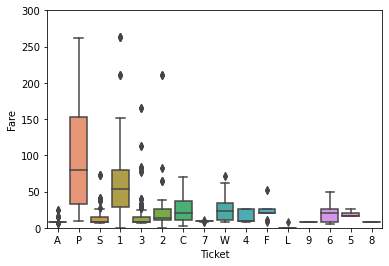

In [40]:
# boxplot to visualize the distribution of Fare for each Ticket
sns.boxplot('Ticket','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [42]:
# inspect the correlation between Ticket and Fare 
df[['Ticket', 'Fare']].groupby(['Ticket']).mean()

,Fare
Ticket,
1,65.771211
2,20.235194
3,15.380682
4,16.764036
5,19.262500
6,19.153711
7,9.197438
8,8.397900
9,7.750000


In [43]:
# divide the standard deviation by the mean. A lower ratio gives a tighter distribution of Fare in each Ticket type
df[['Ticket', 'Fare']].groupby(['Ticket']).std() /  df[['Ticket', 'Fare']].groupby(['Ticket']).mean()

,Fare
Ticket,
1,0.817411
2,1.284139
3,1.351244
4,0.497578
5,0.284367
6,0.735873
7,0.080078
8,0.005961
9,0.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


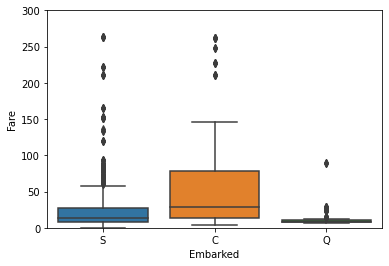

In [44]:
# use boxplot to visualize the distribution of Fare for each Embarked
sns.boxplot('Embarked','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [45]:
# inspect the correlation between Embarked and Fare
df[['Embarked', 'Fare']].groupby(['Embarked']).mean()

,Fare
Embarked,
C,62.336267
Q,12.409012
S,27.418824


In [46]:
# divide the standard deviation by the mean. A lower ratio means a tighter distribution of Fare in each Embarked
df[['Embarked', 'Fare']].groupby(['Embarked']).std() /  df[['Embarked', 'Fare']].groupby(['Embarked']).mean()

,Fare
Embarked,
C,1.350514
Q,1.097278
S,1.352954


In [47]:
# Fare has correlation with these three features. Filling missing value using the median value of (Pcalss = 3) & (Ticket = 3) & (Embarked = S)

In [48]:
guess_Fare = df.Fare.loc[ (df.Ticket == '3') & (df.Pclass == 3) & (df.Embarked == 'S')].median()
df.Fare.fillna(guess_Fare , inplace=True)

# inspect the mean Fare values for people who died and survived
df[['Fare', 'Survived']].groupby(['Survived'],as_index=False).mean()

,Survived,Fare
0,0.0,22.117887
1,1.0,48.395408


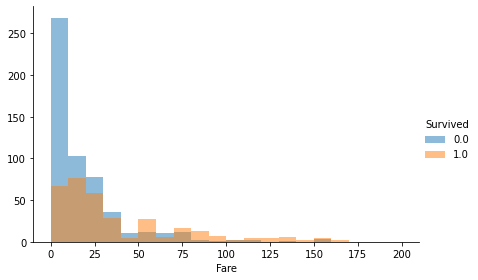

In [49]:
# visualize the distribution of Fare for people who survived and died
grid = sns.FacetGrid(df, hue='Survived', height=4, aspect=1.5)
grid.map(plt.hist, 'Fare', alpha=.5, bins=range(0,210,10))
grid.add_legend()
plt.show()

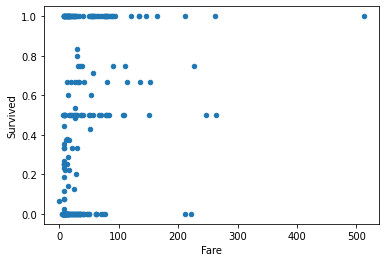

In [50]:
# visualize the correlation between Fare and Survived using a scatter plot
df[['Fare', 'Survived']].groupby(['Fare'],as_index=False).mean().plot.scatter('Fare','Survived')
plt.show()

We can see that people with lower Fare are less likely to survive. This is not a smooth curve if we don't bin the data. Using the original Fare values would cause over-fitting.

In [51]:
# bin Fare into five intervals with equal amount of people
df['Fare-bin'] = pd.qcut(df.Fare,5,labels=[1,2,3,4,5]).astype(int)

# inspect the correlation between Fare-bin and Survived
df[['Fare-bin', 'Survived']].groupby(['Fare-bin'], as_index=False).mean()

,Fare-bin,Survived
0,1,0.217877
1,2,0.201087
2,3,0.426901
3,4,0.443243
4,5,0.645349


Now the correlation is clear after binning the data!

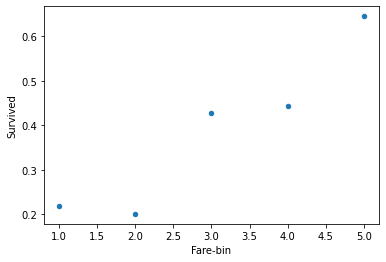

In [52]:
df[['Fare-bin', 'Survived']].groupby(['Fare-bin'],as_index=False).mean().plot.scatter('Fare-bin','Survived')
plt.show()

In [53]:
# cabin
# check for NaN
df.Cabin.isnull().sum(axis=0)

1014

In [54]:
#  too many NaN values. Hence dropping this feature
df = df.drop(labels=['Cabin'], axis=1)

In [55]:
# Embarked
# check if there is any NAN
df.Embarked.isnull().sum(axis=0)

2

In [56]:
df.describe(include=['O']) # S is the most common

,Ticket,Embarked,Title
count,1309,1307,1309
unique,16,3,5
top,3,S,Mr
freq,429,914,757


In [57]:
# fill the NAN with 'S'
df.Embarked.fillna('S' , inplace=True )

In [58]:
# inspecting the correlation between Embarked and Survived as well as some other features
df[['Embarked', 'Survived','Pclass','Fare', 'Age', 'Sex']].groupby(['Embarked'], as_index=False).mean()

# df[['Embarked', 'Survived','Pclass','Fare', 'Age', 'Sex']].groupby(['Embarked'], as_index=False).mean().plot.scatter('Embarked','Survived')
# plt.show()

,Embarked,Survived,Pclass,Fare,Age,Sex
0,C,0.553571,1.851852,62.336267,32.332170,NaN
1,Q,0.389610,2.894309,12.409012,28.630000,NaN
2,S,0.339009,2.344978,27.512485,29.298151,NaN


In [59]:
# people from Embarked = C are more likely to survive because they are generally richer (Pclass, Fare). 
# People from Embarked = S has the lowest survival rate because it has the lowest fraction of female passengers, even though they are a 
# bit richer than people from Embarked = Q.
# hence deciding to drop this feature.
df = df.drop(labels='Embarked', axis=1)

In [60]:
# checking survival rate according to age

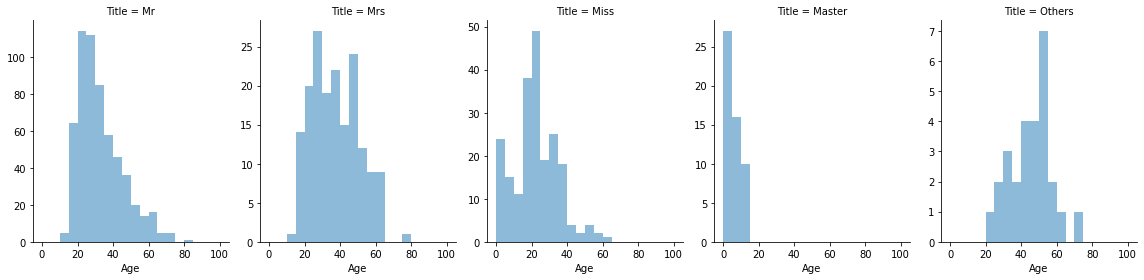

In [61]:
# visualize the correlation between Title and Age
grid = sns.FacetGrid(df, col='Title', height=4, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [62]:
# inspect the mean Age for each Title
df[['Title', 'Age']].groupby(['Title']).mean()

,Age
Title,
Master,5.482642
Miss,21.795236
Mr,32.252151
Mrs,36.930636
Others,45.074074


In [63]:
# inspect the standard deviation of Age for each Title
df[['Title', 'Age']].groupby(['Title']).std()

,Age
Title,
Master,4.161554
Miss,12.192794
Mr,12.422089
Mrs,12.872625
Others,11.303253


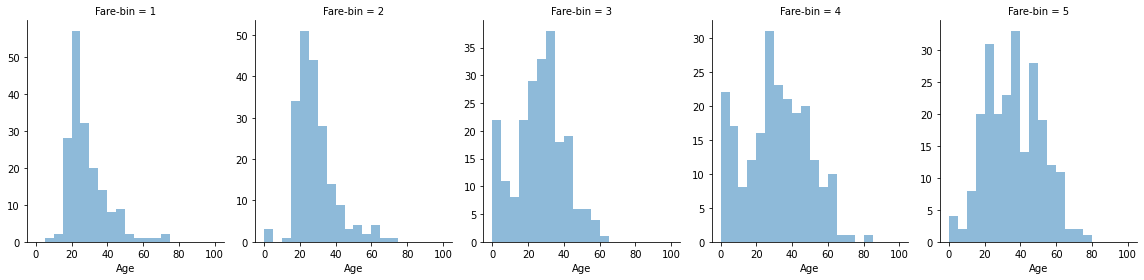

In [64]:
# visualize the correlation between Fare-bin and Age
grid = sns.FacetGrid(df, col='Fare-bin', height=4, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [65]:
# inspect the mean Age for each Fare-bin
df[['Fare-bin', 'Age']].groupby(['Fare-bin']).mean()

,Age
Fare-bin,
1,27.848315
2,27.898241
3,26.144009
4,30.728604
5,35.877913


In [66]:
# inspect the standard deviation of Age for each Fare-bin
df[['Fare-bin', 'Age']].groupby(['Fare-bin']).std()

,Age
Fare-bin,
1,10.812580
2,10.995650
3,13.523208
4,17.466022
5,15.150724


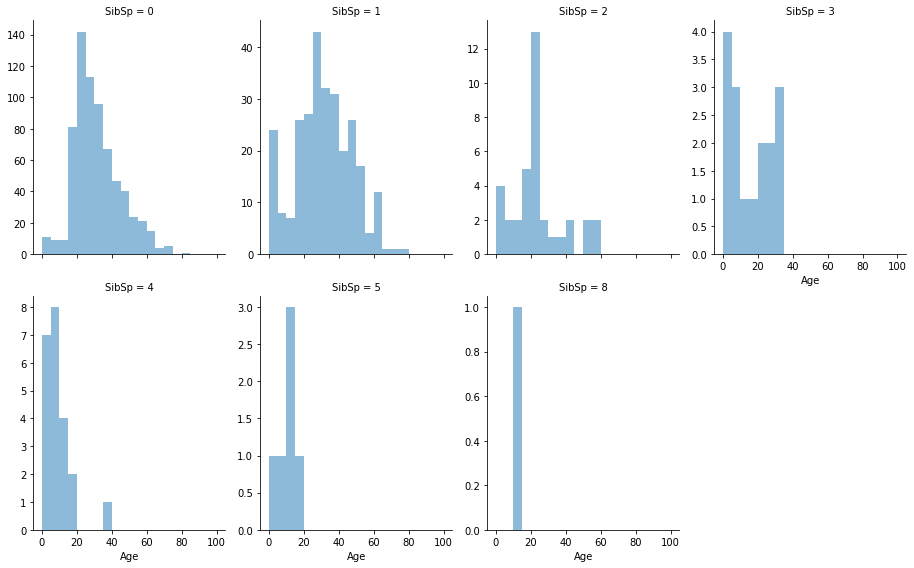

In [67]:
# visualize the correlation between SibSp and Age
grid = sns.FacetGrid(df, col='SibSp', col_wrap=4, height=4.0, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [68]:
# inspect the mean Age for each SibSp
df[['SibSp', 'Age']].groupby(['SibSp']).mean()

,Age
SibSp,
0,30.921766
1,31.058071
2,23.569444
3,16.312500
4,8.772727
5,10.166667
8,14.500000


In [69]:
# inspect the standard deviation of Age for each SibSp
df[['SibSp', 'Age']].groupby(['SibSp']).std()

,Age
SibSp,
0,13.059751
1,15.974482
2,14.910640
3,11.824938
4,8.005545
5,5.192944
8,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


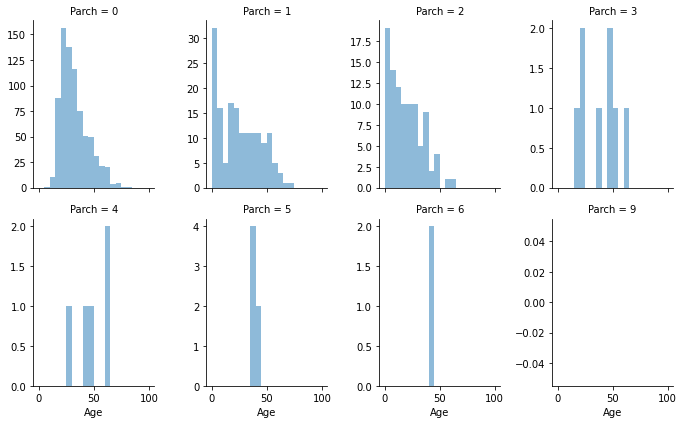

In [70]:
# visualize the correlation between Parch and Age
grid = sns.FacetGrid(df, col='Parch', col_wrap=4, size=3.0, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [71]:
# inspect the mean Age for each Parch
df[['Parch', 'Age']].groupby(['Parch']).mean()

,Age
Parch,
0,31.969401
1,24.965625
2,18.975979
3,38.875000
4,47.600000
5,39.333333
6,41.500000
9,NaN


In [72]:
# inspect the standard deviation of Age for each Parch
df[['Parch', 'Age']].groupby(['Parch']).std() 

,Age
Parch,
0,12.422617
1,18.410885
2,14.564066
3,16.295815
4,14.432602
5,1.032796
6,2.121320
9,NaN


The change of Age as a function of Title, Fare-bin, or SibSp is very significant from the above calculations. Hence using random forest regression to fill in the missing values of the same.

In [73]:
# notice that instead of using Title, using its corresponding dummy variables 
df_sub = df[['Age','Master','Miss','Mr','Mrs','Others','Fare-bin','SibSp']]

X_train  = df_sub.dropna().drop('Age', axis=1)
y_train  = df['Age'].dropna()
X_test = df_sub.loc[np.isnan(df.Age)].drop('Age', axis=1)

regressor = RandomForestRegressor(n_estimators = 300)
regressor.fit(X_train, y_train)
y_pred = np.round(regressor.predict(X_test),1)
df.Age.loc[df.Age.isnull()] = y_pred

# NaN values will be removed now
df.Age.isnull().sum(axis=0) 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0

In [74]:
# bin the data into different Age intervals, similar as Fare, for the same reason that it causes overfitting otherwise
bins = [ 0, 4, 12, 18, 30, 50, 65, 100] # This is somewhat arbitrary
age_index = (1,2,3,4,5,6,7) #('baby','child','teenager','young','mid-age','over-50','senior')
df['Age-bin'] = pd.cut(df.Age, bins, labels=age_index).astype(int)

df[['Age-bin', 'Survived']].groupby(['Age-bin'],as_index=False).mean()


,Age-bin,Survived
0,1,0.675000
1,2,0.452381
2,3,0.402597
3,4,0.315789
4,5,0.427083
5,6,0.375000
6,7,0.125000


In [75]:
# cross verifying changes in ticket section again
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.200000
4,5,0.000000
5,6,0.166667
6,7,0.111111
7,8,0.000000
8,9,1.000000
9,A,0.068966


In [76]:
df['Ticket'].value_counts()

3    429
2    278
1    210
P     98
S     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket, dtype: int64

In [77]:
# From the above count, the main categories of Ticket are "1", "2", "3", "P", "S", and "C", Hence combine all the others into class "4"
df['Ticket'] = df['Ticket'].replace(['A','W','F','L','5','6','7','8','9'], '4')

# check the correlation again
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.166667
4,C,0.340426
5,P,0.646154
6,S,0.323077


In [78]:
# Modeling and Prediction
# drop the features that are not needed and split the data into training and test sets. Then use Keras to build a neural network architecture.
df = df.drop(labels=['SibSp','Parch','Age','Fare','Title'], axis=1)
y_train = df[0:891]['Survived'].values
X_train = df[0:891].drop(['Survived','PassengerId'], axis=1).values
X_test  = df[891:].drop(['Survived','PassengerId'], axis=1).values

In [79]:
# Initialising the NN
model = Sequential()

# layers
model.add(Dense(9, kernel_initializer = 'uniform', activation = 'relu', input_dim = 17))
model.add(Dense(9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 162       
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 308
Trainable params: 308
Non-trainable params: 0
_________________________________________________________________


In [81]:
import sys
import tensorflow as tf
import keras

In [82]:
# Compiling the NN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the NN
model.fit(X_train, y_train, batch_size = 32, epochs = 200)

ValueError: ignored

In [ ]:
# produce the prediction.
y_pred = model.predict(X_test)
y_final = (y_pred > 0.5).astype(int).reshape(X_test.shape[0])

output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_final})
output.to_csv('prediction.csv', index=False)